In [1]:
# !pip3 install box2d-py
# !pip3 install gym[Box_2D]
# %pip install ribs[all] gym~=0.17.0 Box2D~=2.3.10 tqdm


In [13]:
import gym
import numpy as np
import random
import time 
import matplotlib.pyplot as plt
from collections import namedtuple

import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# plotting
%matplotlib inline
import time
import pylab as pl
from IPython import display
import pickle as pkl

Similar to the DQN task, the basic structure of the code is used from the lab material as a starting point.

In [3]:
env = gym.make("LunarLander-v2")
print(env.action_space) #[Output: ] Discrete(2)
print(env.observation_space) # [Output: ] Box(4,)


Discrete(4)
Box([-inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf], (8,), float32)


In [4]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [5]:
class ReplayMemory:

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def save_transition(self, state, action, next_state, reward):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        state_tensor = T.from_numpy(state)
        
        if next_state is None:
            state_tensor_next = None            
        else:
            state_tensor_next = T.from_numpy(next_state)
        
        action_tensor = T.tensor([action], device=device).unsqueeze(0)

        reward = T.tensor([reward], device=device).unsqueeze(0)/10. # reward scaling

        self.memory[self.position] = Transition(state_tensor, action_tensor, state_tensor_next, reward)  # save the transition
        self.position = (self.position + 1) % self.capacity  # loop around memory

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [6]:
# if gpu is to be used
device = T.device("cuda" if T.cuda.is_available() else "cpu")

class DQN(nn.Module):

    def __init__(self, input_size, size_hidden, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, size_hidden)
        self.fc2 = nn.Linear(size_hidden, size_hidden)   
        self.fc3 = nn.Linear(size_hidden, size_hidden)  
        self.fc4 = nn.Linear(size_hidden, output_size)
        
        
    def forward(self, x):
        h1 = F.relu(self.fc1(x.float()))  # self.bn1()
        h2 = F.relu(self.fc2(h1))  # self.bn2()
        h3 = F.relu(self.fc3(h2))  # self.bn3()
        output = self.fc4(h3) # .view(h3.size(0), -1)
        return output

In [7]:
OBS_SIZE = 8
HIDDEN_SIZE = 64
ACTION_SIZE = 4

Q_network = DQN(OBS_SIZE, HIDDEN_SIZE, ACTION_SIZE).to(device)
Q_target = DQN(OBS_SIZE, HIDDEN_SIZE, ACTION_SIZE).to(device)
Q_target.load_state_dict(Q_network.state_dict())
Q_target.eval()

TARGET_UPDATE = 20

optimizer = optim.Adam(Q_network.parameters(), lr=0.001)
memory = ReplayMemory(100000)

In [8]:
class E_Greedy_Policy():
    
    def __init__(self, epsilon, decay, min_epsilon):
        
        self.epsilon = epsilon
        self.epsilon_start = epsilon
        self.decay = decay
        self.epsilon_min = min_epsilon
                
    def __call__(self, state):
                
        is_greedy = random.random() > self.epsilon
        if is_greedy :
            # we select greedy action
            with T.no_grad():
                Q_network.eval()
                index_action = Q_network(state).argmax().detach().cpu().numpy().item()  # state is on cpu instead of GPU!
                Q_network.train()

        else:
            # we sample a random action
            index_action = env.action_space.sample() # select random action (4 possible values)
        
        return index_action
                
    def update_epsilon(self):
        
        self.epsilon = self.epsilon*self.decay
        if self.epsilon < self.epsilon_min:
            self.epsilon = self.epsilon_min
        
    def reset(self):
        self.epsilon = self.epsilon_start

In [9]:
policy = E_Greedy_Policy(epsilon=0.5, decay=0.997, min_epsilon=0.001)
BATCH_SIZE = 64
GAMMA = 0.99

def optimize_model():
    
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = T.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=T.bool)
    non_final_next_states = T.cat([s for s in batch.next_state if s is not None])
    non_final_next_states = T.reshape(non_final_next_states, (non_final_mask.sum(), -1)).float().to(device)  # Reshape to (nr. non final, 8)

    state_batch = T.cat(batch.state).float().to(device)  # .float().to(device) to move to GPU
    state_batch = T.reshape(state_batch, (BATCH_SIZE, -1))  # Reshape to (batch_size, 8)
    action_batch = T.cat(batch.action).to(device)
    reward_batch = T.cat(batch.reward).float().to(device)
    

  
    # Compute Q values using policy net
    Q_values = Q_network(state_batch).gather(1, action_batch)
    # Compute next Q values using Q_targets
    next_Q_values = T.zeros( BATCH_SIZE, device=device).to(device)


    # DDQN Implementation 
    ddqn_idx = Q_network(non_final_next_states).argmax(dim=1, keepdim=True)

    next_Q_values[non_final_mask] = Q_target(non_final_next_states).gather(1, ddqn_idx).detach().flatten()
    next_Q_values = next_Q_values.unsqueeze(1)

        # Compute targets
    target_Q_values = (next_Q_values * GAMMA) + reward_batch

    
    
    # Compute MSE Loss
    loss = F.mse_loss(Q_values, target_Q_values)
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    # Trick: gradient clipping
    for param in Q_network.parameters():
        param.grad.data.clamp_(-1, 1)
        
    optimizer.step()
    
    return loss

In [10]:
env = gym.make("LunarLander-v2")  # create environment

num_episodes = 1500
policy.reset()
rewards_history = []

# Warmup phase!
memory_filled = False
print("Warmup phase...")
while not memory_filled:
    
    state = env.reset()  # 8 states: coordinates of the lander (x,y), linear velocities (x,y), angle, angular velocity, 2 bools if each leg is touches ground.
    done = False
    total_reward = 0
    
    while not done:  # for each episode
        # Get action and act in the world
        state_tensor = T.from_numpy(state).float().to(device)
        action = policy(state_tensor)  # <<--- choose greedy (choose index of highest q-value predicted by network) or exploration
        next_state, reward, done, __ = env.step(action)
        total_reward += float(reward)
        

               # Observe new state
        if done:
            next_state = None

        # Store the transition in memory
        memory.save_transition(state, action, next_state, float(reward))
        state = next_state

    memory_filled = memory.capacity == len(memory)

print('Done with the warmup')
    
for i_episode in range(num_episodes):
    # New dungeon at every run
    state = env.reset()
    done = False
    total_reward = 0
    
    
    while not done:  # iterate through states
        
        # Get action and act in the world
        state_tensor = T.from_numpy(state).float().to(device)  # <<--- convert state to tensor and move to GPU
        
        action = policy(state_tensor)   # choose greedy (index of q-value predictions) or exploration
        next_state, reward, done, __ = env.step(action)
        total_reward += float(reward)


                # Observe new state
        if done:
            next_state = None
        memory.save_transition(state, action, next_state, float(reward))  # Store the transition in memory
        state = next_state  # Move to the next state

        # Perform one step of the optimization
        #started_training = True
        loss = optimize_model()

    policy.update_epsilon()
    rewards_history.append( float(total_reward) )

    
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        Q_target.load_state_dict(Q_network.state_dict())
    
    if i_episode % 10 == 0:
        avg_rewards_10 = sum(rewards_history[-10:])/10

        print('Episode {} - reward: {:.3f}, avg. reward (past 10 ep.): {:.3f}, eps: {:.3f} loss: {:.3f} '.format(
            i_episode, total_reward, avg_rewards_10, policy.epsilon, loss))   
    
print('Complete')

Warmup phase...
Done with the warmup
Episode 0 - reward: -155.330, avg. reward (past 10 ep.): -15.533, eps: 0.498 loss: 0.051 
Episode 10 - reward: -151.771, avg. reward (past 10 ep.): -238.568, eps: 0.484 loss: 0.492 
Episode 20 - reward: -175.376, avg. reward (past 10 ep.): -170.186, eps: 0.469 loss: 0.048 
Episode 30 - reward: -190.880, avg. reward (past 10 ep.): -111.349, eps: 0.456 loss: 0.022 
Episode 40 - reward: -65.409, avg. reward (past 10 ep.): -108.922, eps: 0.442 loss: 0.012 
Episode 50 - reward: -143.870, avg. reward (past 10 ep.): -108.803, eps: 0.429 loss: 0.321 
Episode 60 - reward: 2.813, avg. reward (past 10 ep.): -75.501, eps: 0.416 loss: 0.047 
Episode 70 - reward: -44.797, avg. reward (past 10 ep.): -77.490, eps: 0.404 loss: 0.269 
Episode 80 - reward: -109.620, avg. reward (past 10 ep.): -51.713, eps: 0.392 loss: 0.014 
Episode 90 - reward: -83.411, avg. reward (past 10 ep.): -51.811, eps: 0.380 loss: 0.052 
Episode 100 - reward: -26.393, avg. reward (past 10 ep.

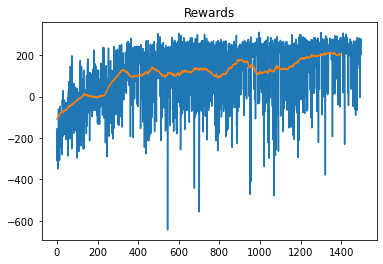

In [11]:
plt.plot(rewards_history, '-')
# add 100 episode moving average
avg_rewards_history = np.convolve(rewards_history, np.ones((100,))/100, mode='valid')
plt.plot(avg_rewards_history, '-')
plt.title('Rewards')
plt.show()

In [14]:
# save rewards history
with open('rewards_history_ddqn.pkl', 'wb') as f:
    pkl.dump(rewards_history, f)